In [1]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely.ops import unary_union

import dask_geopandas as dg
from dask import delayed, visualize
from dask.distributed import Client, progress, LocalCluster, get_client
from dask.diagnostics import ProgressBar

import functions as f

# Info

### The below code wasn't used for this project

The purpose of including this notebook in the repository is to demonstrate our attempt at implementing a method capable of handling a large number of objects. Specifically, the task involved buffering these objects and applying a unary union using the GeoPandas and Dask packages.

#### Problem statement

With 2,000,000 objects, we encountered memory constraints that made the buffer and unary union method ineffective. Consequently, we implemented a Dask solution to parallelize the process.

The standard method managed to complete the process in 17 minutes, nearly exhausting the memory, whereas our implementation finished it within 15 minutes and was more memory-efficient. However, this implementation failed several times, although we didn't run out of memory or encounter any severe issues.

We faced problems like this:

```C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65427 instead
  warnings.warn(
C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 185.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-05-01 20:47:02,527 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:65456 (pid=17256) exceeded 95% memory budget. Restarting...
2024-05-01 20:47:02,558 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:65456' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'UnaryUnion-05b6f3e1-e6e4-48f9-80a0-87fc236de0a8', 'UnaryUnion-0cf67659-628f-484f-aa06-7c638d995704'} (stimulus_id='handle-worker-cleanup-1714589222.5569327')
2024-05-01 20:47:05,968 - distributed.nanny - WARNING - Restarting worker" 
```

Below a screenshot about the CPU and memory usage details.

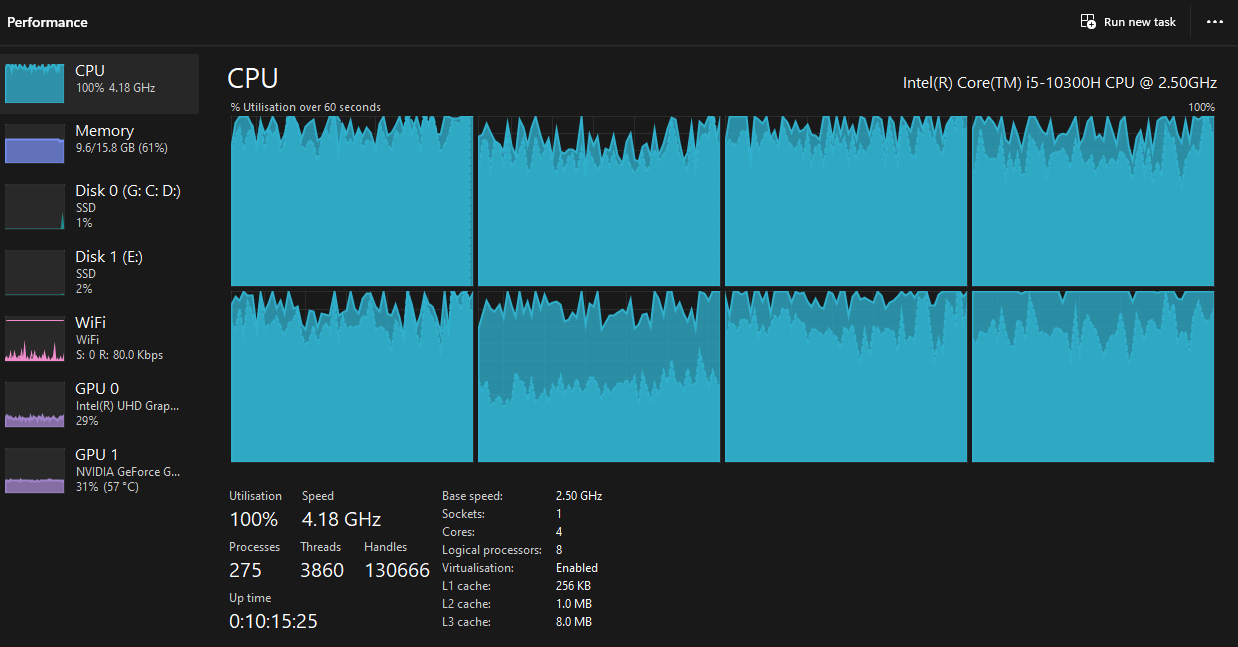

#### Dask is unrelieable somtimes
Choose carefully the parameters of the computation otherwise geodask run  out the memory and became unreliable 

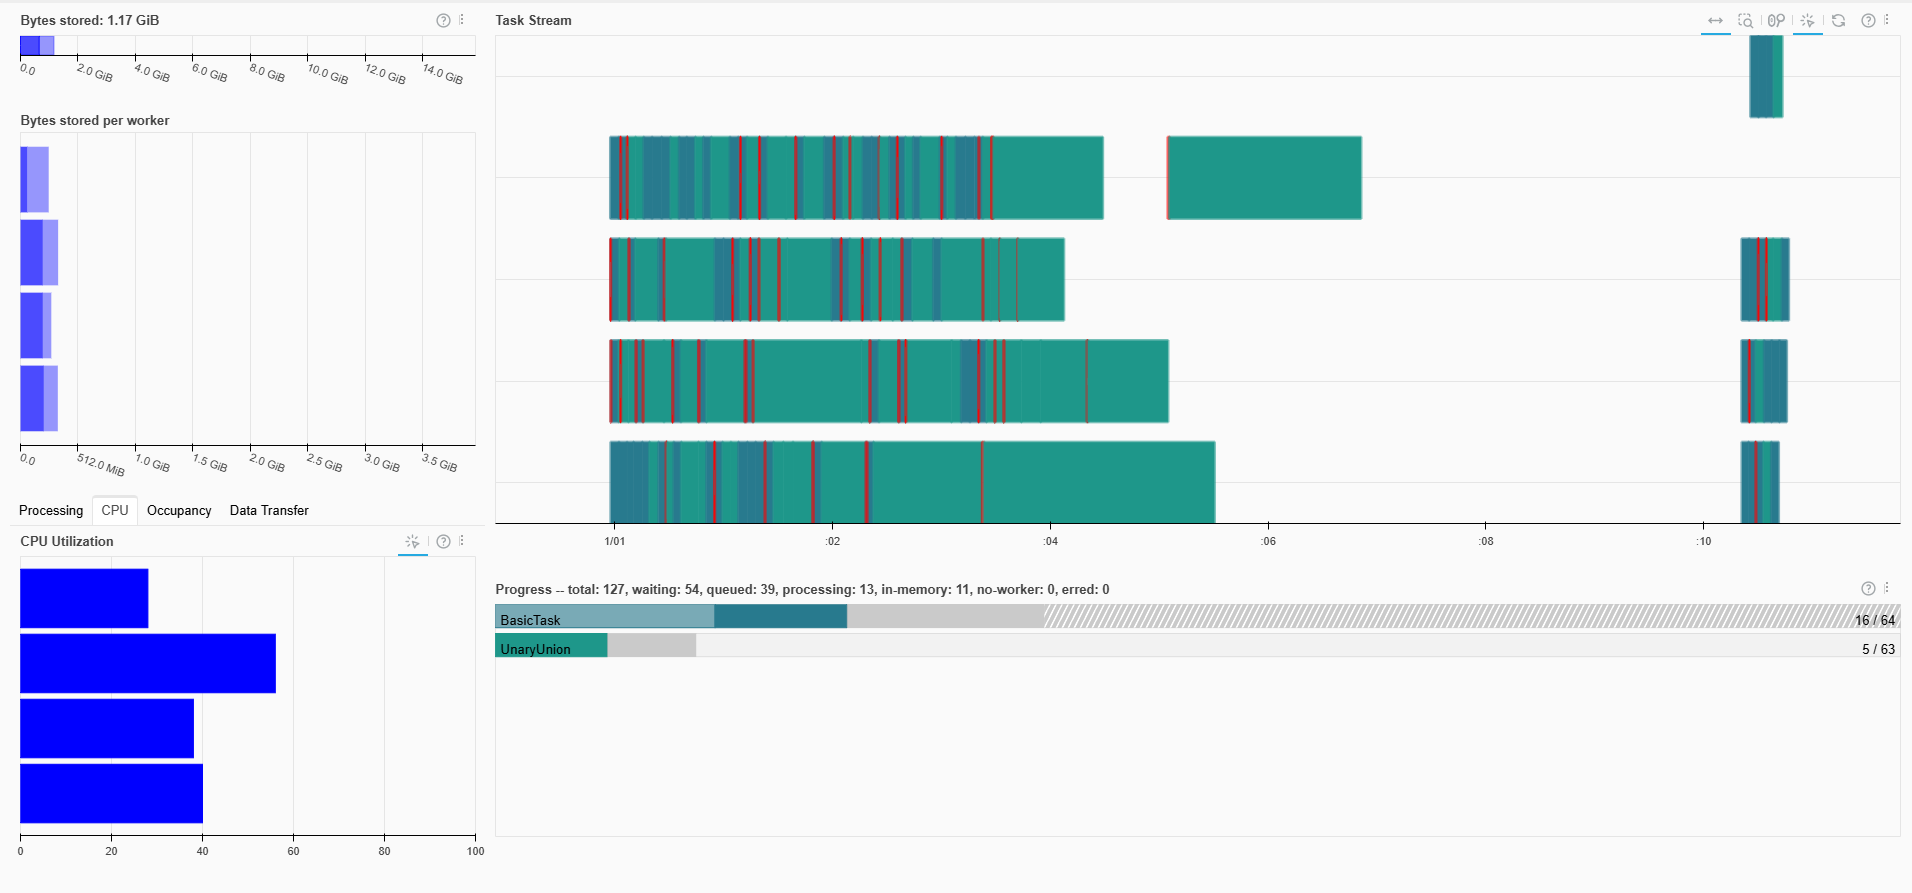

# DASK implementation

With the code below, we aim to present a potential solution that can manage large datasets for buffering and applying unary union operations.

In [2]:
# BUFFER controls the buffer distance around the input geometries in meters (be cautious about the projection).
BUFFER = 50

# We randomly sampled some objects.
# SAMPLE = 2_000_000
SAMPLE = 500_000

# RESOLUTION controls the accuracy of the buffering method in geopandas. Lower values can help conserve memory resources.
RESOLUTION = 8

# PARTITIONS controls how many partitions the Dask GeoPandas DataFrame will have, functioning as chunks.
PARTITIONS = 16

In [3]:
bikelane_wgs84 = gpd.read_parquet('dataset/raw_unprocessed/bikelane_dk_WGS84_h3_indexed.parquet')
bikelane_wgs84_demo = bikelane_wgs84.sample(SAMPLE)
# bikelane_wgs84_demo = bikelane_wgs84
bikelane_wgs84_demo.sort_values('h3_index', inplace=True)
bikelane_wgs84_demo = bikelane_wgs84_demo.reset_index(drop=True)
bikelane_dk_demo = bikelane_wgs84_demo.to_crs(f.DENMARK_CRS)
#bikelane_dk_demo.geometry = shapely.set_precision(bikelane_dk_demo.geometry, grid_size=1)
len(bikelane_dk_demo)

500000

Free up some memory - just in case

In [4]:
# free up some memory. It means nearly 800 MB in case of 500_000 samples
try:
    del bikelane_wgs84
    del bikelane_wgs84_demo
except:
    None

# Implementation 1 - It fails sometimes

Below code fails sometimes. Don't run it

In [7]:
# Function to apply unary_union on each partition
def apply_unary_union(df):
    return gpd.GeoSeries([unary_union(df.geometry)])

# Function to apply buffer and then unary_union on each partition
def apply_buffer_and_unary_union(df):
    # Buffer the geometries in each partition
    buffered = df.geometry.buffer(BUFFER, resolution=RESOLUTION)
    # Apply unary_union to the buffered geometries
    return gpd.GeoSeries([unary_union(buffered)])

# Convert GeoDataFrame to Dask-GeoDataFrame
dask_gdf = dg.from_geopandas(bikelane_dk_demo, npartitions=PARTITIONS)  # Adjust npartitions based on your system
print("dask is ready")
# Apply buffer and unary_union on each partition
buffered_and_unified = dask_gdf.map_partitions(apply_buffer_and_unary_union, meta=('geometry', 'geometry'))
print("buffered_and_unified is ready")

# Optionally, compute the result, which triggers the computation across partitions
with ProgressBar():
    result = buffered_and_unified.compute()
print("result is ready")
final_result = f.geoseries_to_geopandas(result, f.DENMARK_CRS)
print("final_result is ready")


# SAVE the result
# final_result.to_parquet('dataset/raw_unprocessed/bikelane_FINAL.parquet')

dask is ready
buffered_and_unified is ready
[########################################] | 100% Completed | 51.31 s
result is ready
final_result is ready


# Implementation 2 - Working implementation

Reading in again the dataset, convert them

In [16]:
bikelane_wgs84 = gpd.read_parquet('dataset/raw_unprocessed/bikelane_dk_WGS84_h3_indexed.parquet')
bikelane_wgs84_demo = bikelane_wgs84.sample(SAMPLE)
# bikelane_wgs84_demo = bikelane_wgs84
bikelane_wgs84_demo.sort_values('h3_index', inplace=True)
bikelane_wgs84_demo = bikelane_wgs84_demo.reset_index(drop=True)
bikelane_dk_demo = bikelane_wgs84_demo.to_crs(f.DENMARK_CRS)
#bikelane_dk_demo.geometry = shapely.set_precision(bikelane_dk_demo.geometry, grid_size=1)
len(bikelane_dk_demo)

d_gdf = dg.from_geopandas(bikelane_dk_demo, npartitions=PARTITIONS)

In [17]:
# free up some memory. It means nearly 800 MB in case of 500_000 samples
try:
    del bikelane_wgs84
    del bikelane_wgs84_demo
    del final_result
    del dask_gdf
    del buffered_and_unified
except:
    None


### Overview of the Computation Tree
The computation tree effectively manages memory and computational efficiency through a structured reduction of tasks, ultimately leading to a single result. It leverages Dask's lazy evaluation, where computations are delayed until the final result is needed, reducing memory overhead by discarding intermediate results.

#### Process Explained
BasicTask Function: Each BasicTask function call processes a partition of your dataset. It performs buffering operations to expand the geometries by a specified buffer distance, which helps in creating a unified spatial representation of data points. The resultant geometry undergoes a unary union within each partition, simplifying the structure to a single multipolygon. This helps in reducing complexity and memory usage before further operations.

UnaryUnion Function: This function is a binary operation where two geospatial dataframes from the previous steps are concatenated. The unary union of these concatenated geometries is calculated to merge overlapping or adjacent polygons, effectively reducing the number of separate geometrical entities and further simplifying the data structure.

Reduce Partitions: This recursive function builts up the tree structure of the computation.

Visualization: The tree structure in your visualization reflects the hierarchical reduction of data partitions, where each level of the tree combines results from the previous level until a single output is obtained.
Memory Management: By only storing the results of the UnaryUnion at each stage and discarding intermediate results, the tree structure helps manage memory effectively. It ensures that only necessary data is kept in memory at any time, which is crucial for handling large datasets.

In [18]:
@delayed
def BasicTask(gdf):

    gdf = gdf.buffer(BUFFER, resolution=RESOLUTION)

    gdf = f.geoseries_to_geopandas(gdf, crs=f.DENMARK_CRS)
    gdf = f.multipolygon_to_gdf(gdf.unary_union, crs=f.DENMARK_CRS)

    #gdf = DENMARK.intersection(gdf)

    #gdf = f.geoseries_to_geopandas(gdf, crs=f.DENMARK_CRS)
    #done.to_parquet(f'dataset/processed/bikelane_{t}_minutes_dk.parquet')
    return gdf

@delayed
def UnaryUnion(gdf1, gdf2):
    # Assuming gdf1 and gdf2 are your GeoDataFrames
    combined_gdf = gpd.GeoDataFrame(pd.concat([gdf1.geometry, gdf2.geometry], ignore_index=True))

    # Now compute the unary union
    #unary_union_result = combined_gdf.explode().unary_union
    unary_union_result = combined_gdf.unary_union
    gdf = f.multipolygon_to_gdf(unary_union_result, crs=f.DENMARK_CRS)

    return gdf

# Load and process partitions
load = [BasicTask(d_gdf.get_partition(i).compute()) for i in range(PARTITIONS)]

# Recursive function to reduce partitions by applying UnaryUnion
def reduce_partitions(partitions):
    if len(partitions) <= 1:
        return partitions
    reduced = []
    for i in range(0, len(partitions), 2):
        if i + 1 < len(partitions):
            reduced.append(UnaryUnion(partitions[i], partitions[i+1]))
        else:
            reduced.append(partitions[i])
    return reduce_partitions(reduced)

final_result = reduce_partitions(load)

Task exception was never retrieved
future: <Task finished name='Task-23761' coro=<Client._gather.<locals>.wait() done, defined at C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

#### Visualizing the computation tree

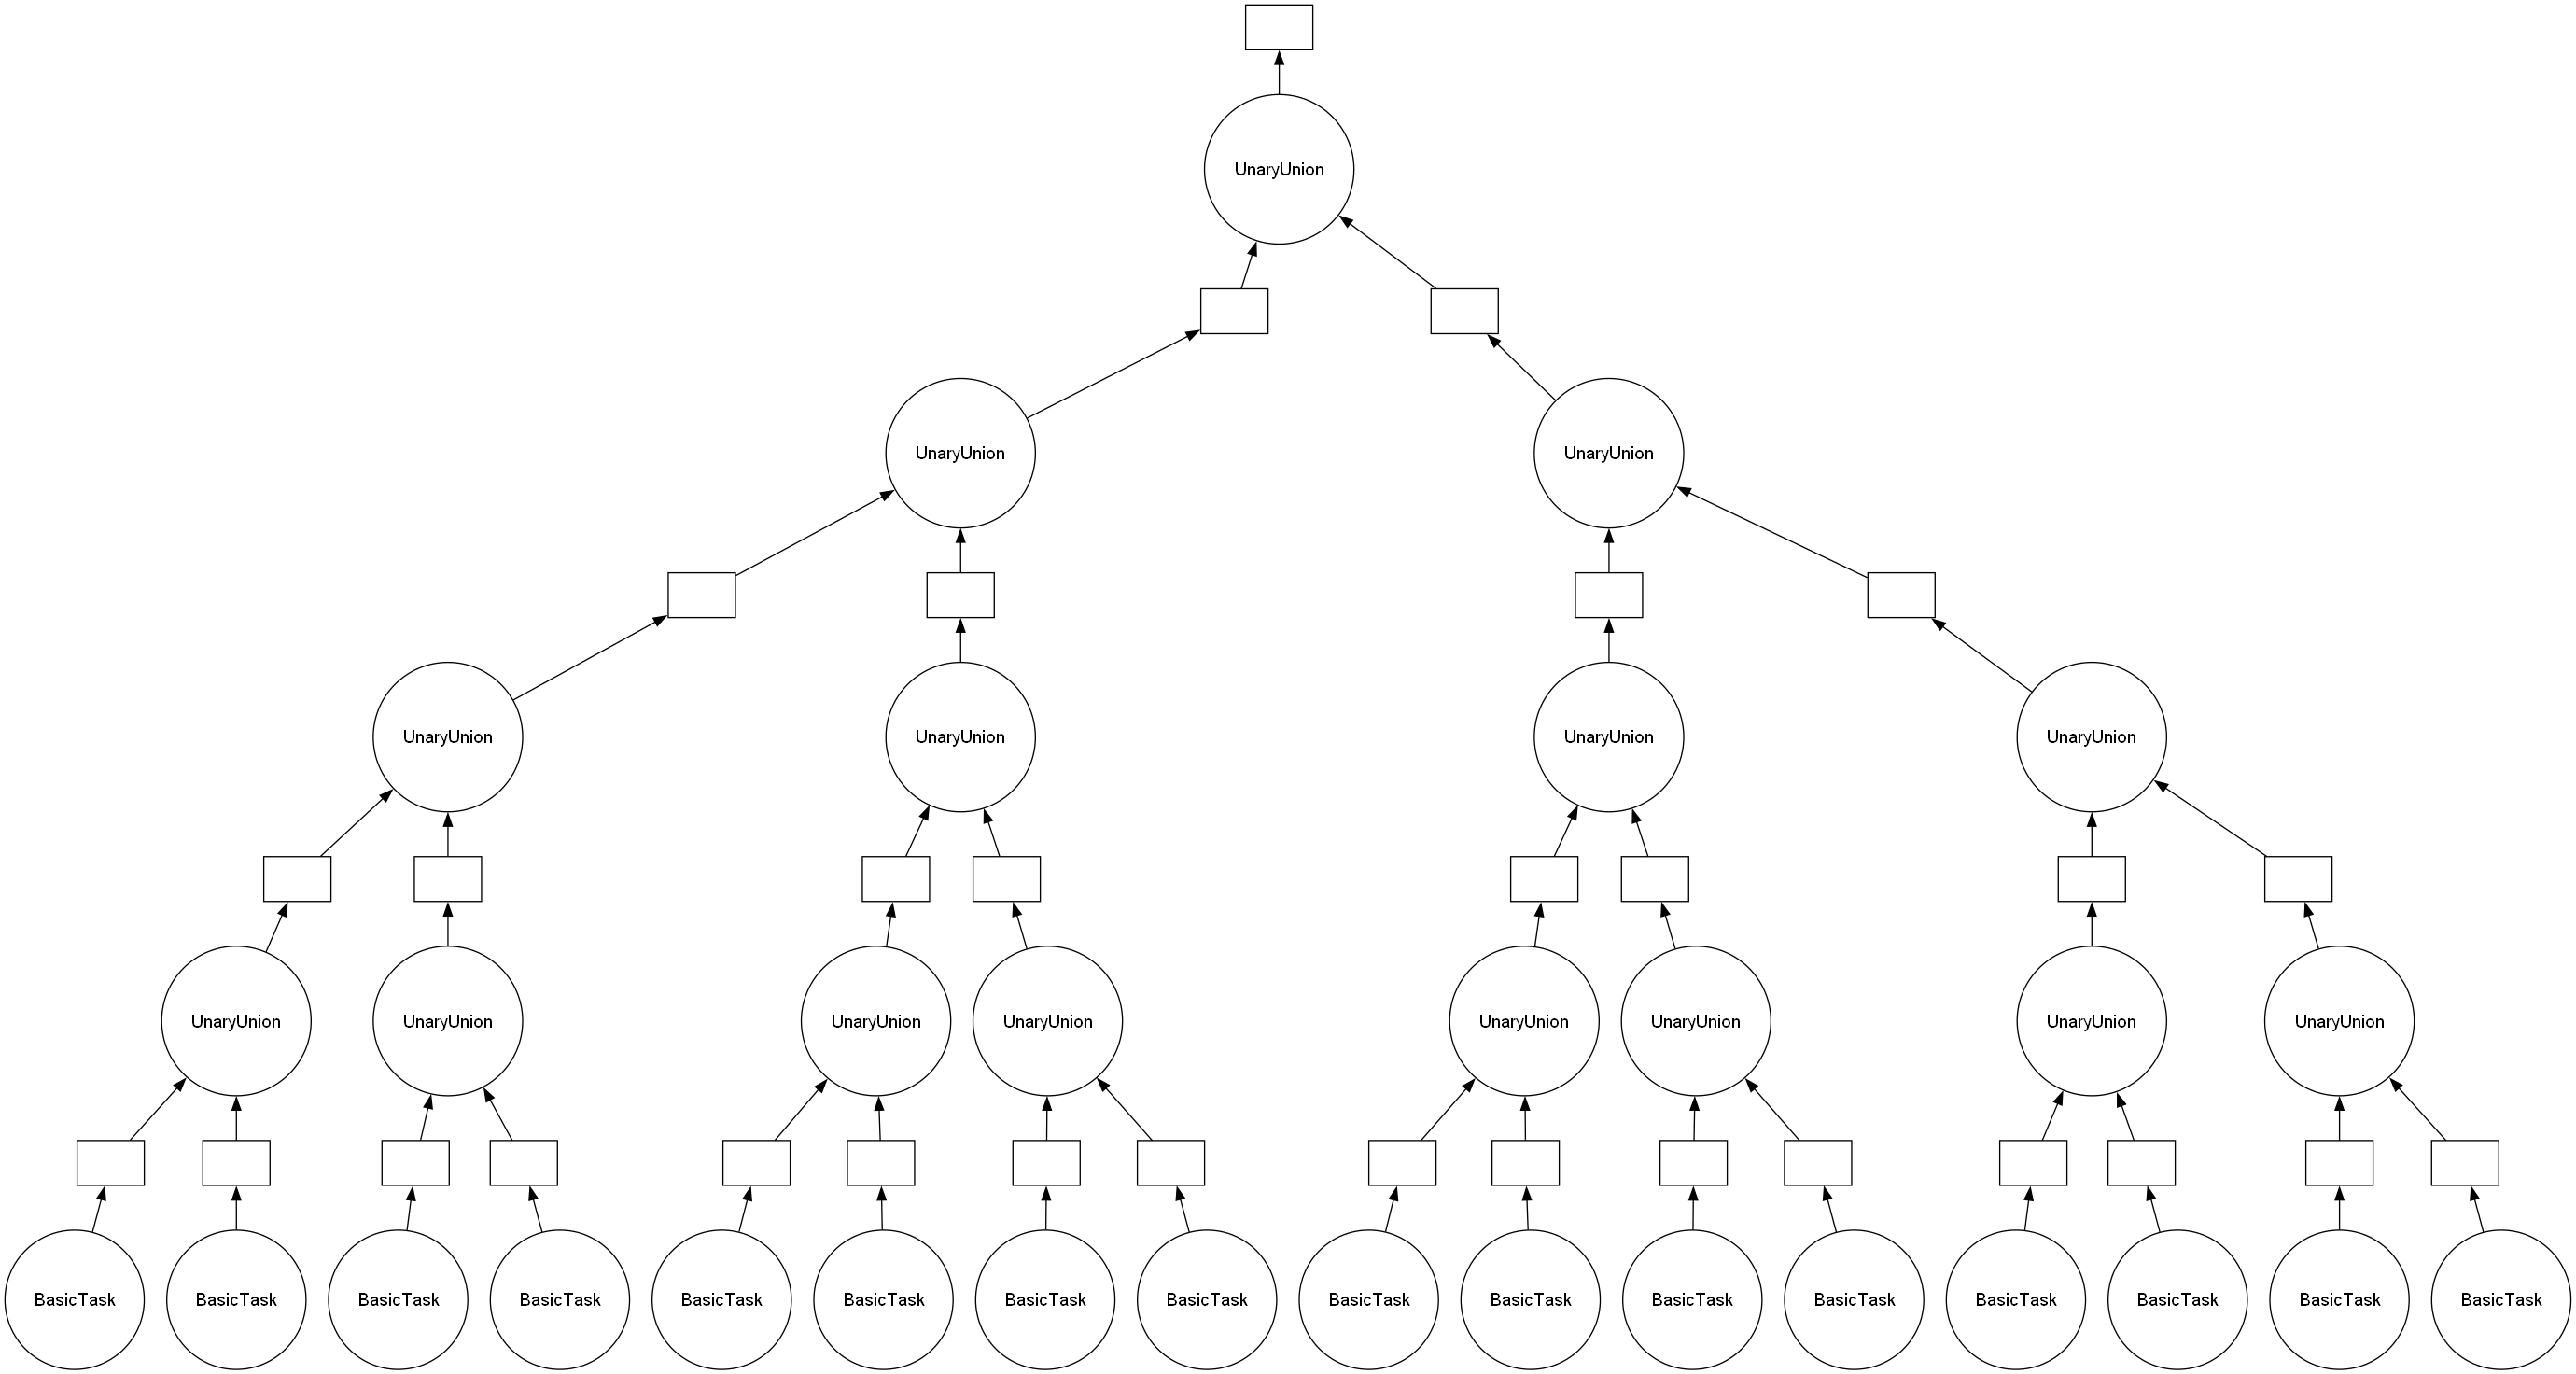

In [ ]:
visualize(final_result)

In [ ]:
# Yo can open your browser to follow the process. Use this address:
# 127.0.0.1:8787

cluster = LocalCluster(dashboard_address='127.0.0.1:8787',
                        worker_dashboard_address='127.0.0.1:8787',
                        n_workers=4,
                        threads_per_worker=1)

client = Client(cluster)

Below code starts the computation process

In [ ]:
result = client.compute(final_result[0])
final_result_df = result.result()

KeyboardInterrupt: 